In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [1]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [4]:
len(tf.config.list_physical_devices('GPU'))>0

True

!pip install transformers <br>
!pip install pycaret --user <br>
!pip install --upgrade scikit-learn

In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
device = torch.device("cuda")

In [3]:
true_data = pd.read_csv('C:/Users/akash/Downloads/News-_dataset/True.csv')
fake_data = pd.read_csv('C:/Users/akash/Downloads/News-_dataset/Fake.csv')

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

data = true_data.append(fake_data).sample(frac = 1).reset_index().drop(columns=['index'])

print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Congrats To Nasty Little Globalist And Bilderb...,Paul Joseph Watson nails it in this look at th...,politics,"May 7, 2017",Fake
1,House Speaker Ryan briefed Trump on healthcare...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 24, 2017",True
2,Progressive Lunacy: PETA Claims Indonesian Mon...,21st Century Wire says You know that western s...,US_News,"July 17, 2017",Fake
3,"As Brexit deal takes shape, Juncker to meet MEPs",BRUSSELS (Reuters) - The European Commission a...,worldnews,"December 3, 2017",True
4,Trump picks former U.N. spokesman Grenell for ...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 21, 2017",True


In [4]:
data['label'] = pd.get_dummies(data.Target)['Fake']

In [5]:
data.head()

,title,text,subject,date,Target,label
0,Congrats To Nasty Little Globalist And Bilderb...,Paul Joseph Watson nails it in this look at th...,politics,"May 7, 2017",Fake,1
1,House Speaker Ryan briefed Trump on healthcare...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 24, 2017",True,0
2,Progressive Lunacy: PETA Claims Indonesian Mon...,21st Century Wire says You know that western s...,US_News,"July 17, 2017",Fake,1
3,"As Brexit deal takes shape, Juncker to meet MEPs",BRUSSELS (Reuters) - The European Commission a...,worldnews,"December 3, 2017",True,0
4,Trump picks former U.N. spokesman Grenell for ...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 21, 2017",True,0


([<matplotlib.patches.Wedge at 0x182889b77f0>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.298546%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.701457%')])

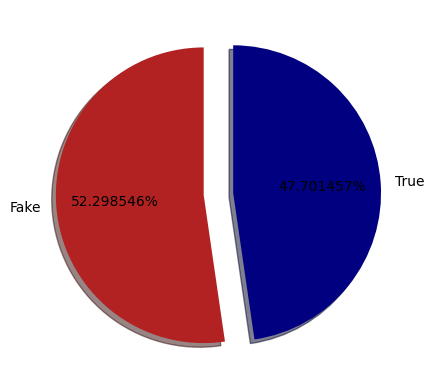

In [6]:
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct= '%f%%')

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size = 0.3,
                                                                    stratify=data['Target'])
val_text, test_text,val_labels,test_labels=train_test_split(temp_text,temp_labels,
                                                           random_state=2018,
                                                           test_size=0.5,
                                                           stratify=temp_labels)

In [8]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0.5, 0, 'Number of texts')

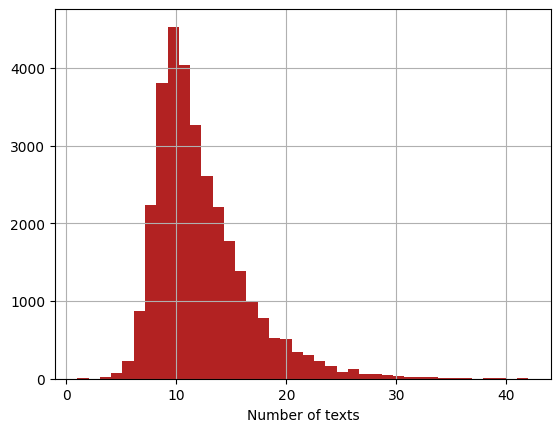

In [9]:
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len) .hist(bins = 40, color = 'firebrick')
plt.xlabel('Number of Words')
plt.xlabel('Number of texts')

In [10]:
sample_data = ["Build fake news model.",
               "Using bert."]
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)
print(tokenized_sample_data)

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [11]:
MAX_LENGTH = 15

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq,train_mask,train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler = train_sampler,batch_size=batch_size)

val_data = TensorDataset(val_seq,val_mask,val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data,sampler = val_sampler,batch_size=batch_size)

In [14]:
for param in bert.parameters():
    param.requires_qrad = False

In [15]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

model = BERT_Arch(bert)
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)
cross_entropy  = nn.NLLLoss()
epochs = 2

In [16]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return avg_loss

def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:


      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

In [ ]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

### For loading states of the Model and not the whole Model
path = 'c1_fakenews_weights.pt'
model.load_state_dict(torch.load(path))


In [17]:
#For loading full model
path = 'Model.pt'
model=torch.load(path)

In [18]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3212
           1       0.92      0.85      0.88      3523

    accuracy                           0.88      6735
   macro avg       0.88      0.88      0.88      6735
weighted avg       0.89      0.88      0.88      6735



In [25]:
unseen_news_text = ["PM Modi to attend the G7 Summit online to avoid 20% TCS"]


MAX_LENGHT = 100
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([0], dtype=int64)